# Setup

In [1]:
import requests
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from shapely.geometry import polygon, Polygon, MultiPolygon

In [2]:
# Spatial reference for layers
sr = "{'wkid': 3435}"

# Parcels REST service
parcels_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Current_Cadastral_Features/FeatureServer/1/query?'

# SSURGO Soils REST service
soils_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Soils/FeatureServer/0/query?'

# Landuse REST service
landuse_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Landuse/FeatureServer/0/query?'

In [3]:
def get_features(service_url, where='1=1', fields='*', bbox=None):
    """
    
    """
    count_params = {
        'where': where,
        'returnCountOnly': True,
        'geometry': bbox,
        'geometryTrype': 'esriGeometryEnvelope',
        'spatialRel': 'esriSpatialRelIntersects',
        'f': 'json'
    }
    
    count = requests.get(service_url, count_params).json()['count']
    
    print(f"{count} features to query from {service_url}")
    
    i = 0
    
    out_df = gp.GeoDataFrame()
    
    while i < count:
        
        feat_params = {
            'where': where,
            'outFields': fields,
            'outSR': "{'wkid': 3435}",
            'resultOffset': i,
            'resultRecordCount': 1000,
            'returnExceededLimitFeatures': False,
            'geometry': bbox,
            'geometryTrype': 'esriGeometryEnvelope',
            'spatialRel': 'esriSpatialRelIntersects',
            'f': 'geojson'
        }
        
        temp_df = gp.read_file(requests.get(service_url, feat_params).text)
        
        out_df = out_df.append(temp_df)
        
        i += 1000
        
    return out_df

In [4]:
def run_farms(filename=f"farmcalc_{time.strftime('%d%b%Y', time.localtime())}", cond='1=1', return_dfs=False):
    """

    """
    # Only return farm classes; optionally restrict to individual township for performance
    p_df = get_features(
        parcels_url,
        where = f"class IN('0011', '0021') and ({cond})",
        fields = 'pin_dashless,gross_acres'
    )

    bbox = ','.join([str(i) for i in p_df.total_bounds])

    s_df = get_features(
        soils_url,
        fields = 'soil_type,slope',
        bbox = bbox
    )

    # Omit non-ag and hydro LU types, not in destination schema
    l_df = get_features(
        landuse_url,
        fields = 'landuse_type',
        bbox = bbox
    )

    # Landuse types to strings
    l_df.loc[:, 'landuse_type'] = '0' + l_df['landuse_type'].astype('str')

    # Get calculated area of parcel features
    p_df['calc_area'] = p_df.area

    # Overlay
    temp_df = gp.overlay(p_df, l_df, how='intersection')
    df = gp.overlay(temp_df, s_df, how='intersection')

    # Get area of parts
    df['part_acres'] = df.area / df['calc_area'] * df['gross_acres']

    # Aggregate data
    out_cols = ['pin_dashless', 'soil_type', 'slope', 'landuse_type', 'gross_acres']
    agg_df = df.groupby(by=out_cols, as_index=False).sum()

    # Drop non-parcel areas and slivers
    agg_df = agg_df[agg_df['pin_dashless'].isna() == False]
    agg_df.loc[:, 'part_acres'] = round(agg_df['part_acres'], 4)
    agg_df = agg_df[agg_df.loc[:, 'part_acres'] > 0]
    
    # Quality Control information
    qc = agg_df.groupby(by=['pin_dashless', 'gross_acres']).sum().reset_index()
    qc['diff'] = qc['gross_acres'] - qc['part_acres']
    
    # Plot
    fig, axs = plt.subplots(1,2, figsize=(20, 10))

    df.plot(
        edgecolor='black',
        column='pin_dashless',
        ax=axs[0],
        cmap = 'Dark2'
    )

    qc.plot.scatter(
        x = 'gross_acres',
        y = 'part_acres',
        loglog = True,
        ax = axs[1],
        title = 'Deeded to Summed Acreage: Should be Equal!',
        s = 100,
        c = -qc['diff'],
        cmap = 'RdYlBu',
        colorbar = False,
    )

    axs[0].axis('off')

    outliers = qc.loc[qc['diff'] > 0.1, ['pin_dashless', 'gross_acres', 'part_acres']]

    for n in outliers.index.to_list():
        plt.text(
            outliers.loc[n, 'gross_acres'] * 1.1,
            outliers.loc[n, 'part_acres'],
            outliers.loc[n, 'pin_dashless'],
        )

    plt.show()
    
    # Write file
    agg_df.drop(columns=['gross_acres', 'calc_area']).to_csv(filename + '.txt', sep='\t', header=False, index=False)
    
    if return_dfs:
        return {
            'p_df': p_df,
            's_df': s_df,
            'l_df': l_df,
            'temp': temp_df,
            'df': df,
            'agg_df': agg_df,
            'qc': qc
        }

# Run Farms

15 features to query from https://maps.co.kendall.il.us/server/rest/services/Hosted/Current_Cadastral_Features/FeatureServer/1/query?
54 features to query from https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Soils/FeatureServer/0/query?
346 features to query from https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Landuse/FeatureServer/0/query?


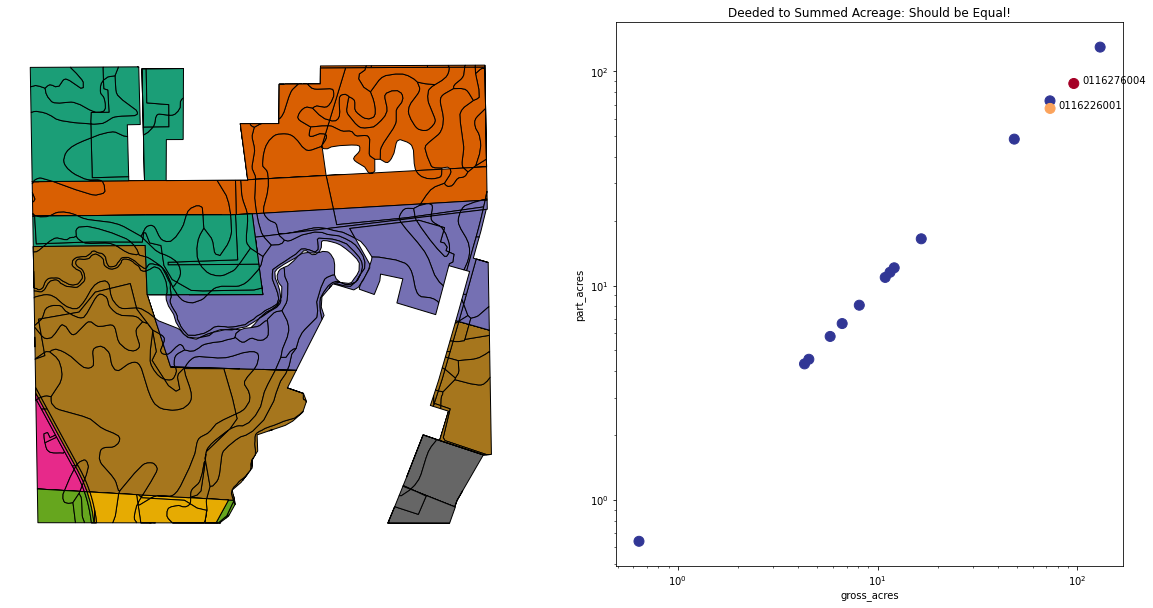

In [9]:
dfs = run_farms(filename = 'test', cond = "pin like '01-16%'", return_dfs=True)

In [7]:
farms = pd.read_csv('c:/users/jcarlson/desktop/farmcalc_22jun2021.txt', sep='\t')

In [11]:
farms[['soil', 'slope', 'landuse', 'pin', 'acres']].fillna('').to_csv('c:/users/jcarlson/desktop/newfarms.txt', sep='\t', header=False, index=False)